# LUKASZ ZAJAC LAB 1 ADZD

ASSIGNMENT:

Korzystając z operacji na RDD i pliku z logami Apache2:

1. Narysować wykres rankingu najpopularniejszych stron źródłowych (referer), z wyłączeniem domeny semicomplete.com

2. Narysować wykres rankingu pobieranych plików graficznych

3. Narysować średni dobowy wykres liczby wywołań (request) na minutę w zależności od czasu.

4. Narysować wykres (pie chart) popularności systemów operacyjnych klienta

5. Oszacować jaki procent ruchu generują boty. Porównać co najmniej 2 sposoby oszacowania.

6. Narysować mapę z lokalizacjami klientów

# Introduction to Apache Spark Resilient Distributed Datasets (RDD)

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar -xvf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

### Initialization ###
Starting Spark session:

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [4]:
spark

In [5]:
sc = spark.sparkContext

### Reading text files

Download a file locally (just for the demo, for larger files use HDFS or S3):

In [6]:
import urllib.request

In [7]:
urllib.request.urlretrieve("http://raw.githubusercontent.com/elastic/examples/master/Common%20Data%20Formats/apache_logs/apache_logs","apache_logs")

('apache_logs', <http.client.HTTPMessage at 0x7a7ee4d28490>)

Create a first RDD

In [8]:
lines = sc.textFile("apache_logs")

Perform a *transformation*

In [9]:
lineLengths = lines.map(lambda s: len(s))

Perform an *action*

In [10]:
totalLength = lineLengths.reduce(lambda a, b: a + b)

Finally evaluate (laziness!)

In [11]:
totalLength

2360789

### Custom functions

In [12]:
def myFunc(s):
    words = s.split(" ")
    return len(words)

In [13]:
wordCounts = lines.map(myFunc)

In [14]:
wordCounts.max()

43

In [15]:
wordCounts.histogram([0,10,20,30,40,50])

([0, 10, 20, 30, 40, 50], [0, 4901, 4719, 378, 2])

In [16]:
wordCounts.count()

10000

### Map-Reduce pattern

Let's look closer at our log file format:

```
99.158.0.150 - - [18/May/2015:04:05:37 +0000] "GET /images/jordan-80.png HTTP/1.1" 200 6146 "http://www.semicomplete.com/articles/dynamic-dns-with-dhcp/" "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Ubuntu Chromium/32.0.1700.102 Chrome/32.0.1700.102 Safari/537.36"
```

Count lines containing "Chrome":

In [17]:
chromeLines = lines.map(lambda s: (1 if "Chrome" in s else 0))

In [18]:
counts = chromeLines.reduce(lambda a, b: a + b)

In [19]:
counts

3172

### Key-Value Pairs

Count IP addresses

In [20]:
regex = '([(\d\.)]+)'

In [21]:
import re

In [22]:
ip = re.match(regex, '99.158.0.150 - - ').group(0)

In [23]:
print(ip)

99.158.0.150


In [24]:
ips = lines.map(lambda s: (re.match(regex, s).group(0) ,1))

In [25]:
ipCounts = ips.reduceByKey(lambda a, b: a + b)

Get results

In [ ]:
ipCounts.collect()

In [27]:
ipCounts.take(20)

[('83.149.9.216', 23),
 ('110.136.166.128', 6),
 ('46.105.14.53', 364),
 ('123.125.71.35', 1),
 ('200.49.190.100', 1),
 ('67.214.178.190', 2),
 ('207.241.237.220', 18),
 ('207.241.237.227', 17),
 ('207.241.237.228', 16),
 ('218.30.103.62', 16),
 ('71.212.224.97', 5),
 ('86.1.76.62', 6),
 ('107.170.41.69', 10),
 ('208.115.111.72', 83),
 ('174.37.205.76', 1),
 ('134.76.249.10', 8),
 ('123.125.71.117', 1),
 ('65.19.138.34', 3),
 ('5.102.173.71', 2),
 ('187.45.193.158', 8)]

Sort by values (ascending):

In [28]:
ipCounts.takeOrdered(10, lambda pair: pair[1])

[('123.125.71.35', 1),
 ('200.49.190.100', 1),
 ('174.37.205.76', 1),
 ('123.125.71.117', 1),
 ('180.76.5.27', 1),
 ('93.164.60.142', 1),
 ('94.175.135.116', 1),
 ('172.56.29.98', 1),
 ('173.252.73.114', 1),
 ('54.226.176.99', 1)]

Sort by values (descending):

In [29]:
topIPs = ipCounts.takeOrdered(10, lambda pair: -pair[1])
topIPs

[('66.249.73.135', 482),
 ('46.105.14.53', 364),
 ('130.237.218.86', 357),
 ('75.97.9.59', 273),
 ('50.16.19.13', 113),
 ('209.85.238.199', 102),
 ('68.180.224.225', 99),
 ('100.43.83.137', 84),
 ('208.115.111.72', 83),
 ('198.46.149.143', 82)]

### Plotting

In [30]:
import pandas as pd

In [31]:
df = pd.DataFrame(topIPs, columns=['IP', 'Count'])
df

,IP,Count
0,66.249.73.135,482
1,46.105.14.53,364
2,130.237.218.86,357
3,75.97.9.59,273
4,50.16.19.13,113
5,209.85.238.199,102
6,68.180.224.225,99
7,100.43.83.137,84
8,208.115.111.72,83
9,198.46.149.143,82


In [32]:
import matplotlib.pyplot as plt

<Axes: ylabel='IP'>

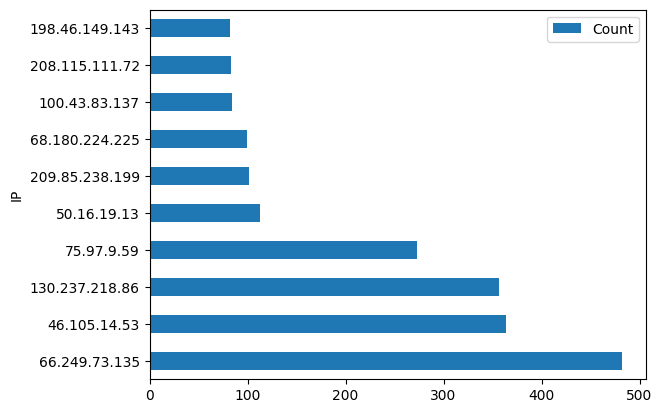

In [33]:
df.plot.barh(x = 'IP')

### Closures and accumulators

Local variables are not passed to closures or functions, they remain local!

In [34]:
counter = 0

# Wrong: Don't do this!!
def increment_counter(x):
    global counter
    counter += x

wordCounts.foreach(increment_counter)

print("Counter value: ", counter)

Counter value:  0


Use *accumulators* instead

In [35]:
accum = sc.accumulator(0)
accum

Accumulator<id=0, value=0>

In [36]:
# Correct way is to use accumulators
def increment_counter(x):
    accum.add(x)

wordCounts.foreach(increment_counter)

print("Counter value: ", accum)

Counter value:  197956


## Assignment solutions

Narysować wykres rankingu najpopularniejszych stron źródłowych (referer), z wyłączeniem domeny semicomplete.com



In [ ]:
lines.collect()

In [38]:
import regex as re
ref_regex = 'https?\:\/\/([^\/\)\"]*)'
test_str = """
17/May/2015:10:05:03 +0000] "GET /presentations/logstash-monitorama-2013/images/kibana-search.png HTTP/1.1" 200 203023 "http://semicomplete.com/presentations/logstash-monitorama-2013/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"',
 '83.149.9.216 - - [17/May/2015:10:05:43 +0000] "GET /presentations/logstash-monitorama-2013/images/kibana-dashboard3.png HTTP/1.1" 200 171717 "http://semicomplete.com/presentations/logstash-monitorama-2013/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"',
 '83.149.9.216 - - [17/May/2015:10:05:47 +0000] "GET /presentations/logstash-monitorama-2013/plugin/highlight/highlight.js HTTP/1.1" 200 26185 "httpss://semicomplete.com/presentations/logstash-monitorama-2013/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"',
 '83.149.9.216 - - [17/May/2015:10:05:12 +0000] "GET /presentations/logstash-monitorama-2013/plugin/zoom-js/zoom.js HTTP/1.1" 200 7697 "https://semicomplete.com/presentations/logstash-monitorama-2013/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"',
 '83.149.9.216 - - [17/May/2015:10:05:07 +0000] "GET /presentations/logstash-monitorama-2013/plugin/notes/notes.js HTTP/1.1" 200 2892 "http://semicomplete.com/presentations/logstash-monitorama-2013/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"',
 '83.149.9.216 - - [17/May/2015:10:05:34 +0000] "GET /presentations/logstash-monitorama-2013/images/sad-medic.png HTTP/1.1" 200 430406 "http://semicomplete.com/presentations/logstash-monitorama-2013/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"'
"""


referers = lines.map( lambda l: (None,1) if re.search(ref_regex,l) is None else (re.search(ref_regex,l).group(0),1) )
referers.collect()
referers_count = referers.reduceByKey(lambda a, b: a + b)
referers_count = referers_count.collect()

In [39]:
df = pd.DataFrame(referers_count, columns=['Ref', 'Count'])
df.sort_values(by=['Count'], ascending=False, inplace=True)

<Axes: ylabel='Ref'>

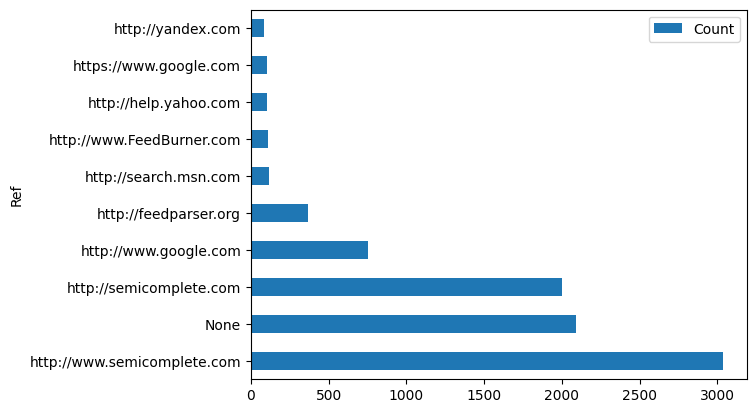

In [40]:
df[:10].plot.barh(x = 'Ref')


Narysować wykres rankingu pobieranych plików graficznych


<Axes: ylabel='File'>

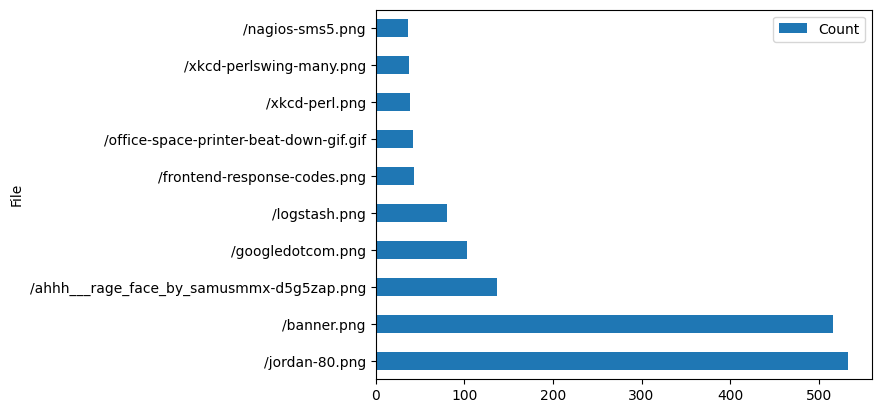

In [41]:
#zakladam ze obrazki maja rozszerzenia png lub jpg
file_regex = r'/([^/]+\.(?:png|jpg|jpeg|gif))'

# Find all matches

image_files = lines.map( lambda l: (None,1) if re.search(file_regex,l) is None else (re.search(file_regex,l).group(0),1) )
image_files.collect()
image_files_count = image_files.reduceByKey(lambda a, b: a + b)
image_files_count = image_files_count.collect()
df = pd.DataFrame(image_files_count, columns=['File', 'Count'])

df.sort_values(by=['Count'], ascending=False, inplace=True)
df[1:11].plot.barh(x = 'File')


Narysować średni dobowy wykres liczby wywołań (request) na minutę w zależności od czasu.


<Axes: xlabel='Time'>

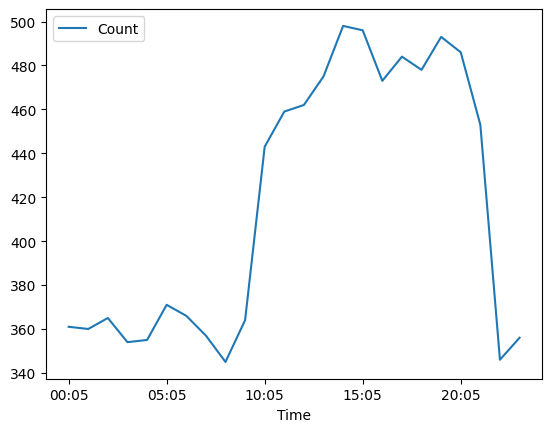

In [48]:
time_regex = r'\[[^\]]*\:([0-9]{2}\:[0-9]{2})\:[0-9]{2} \+[0-9]{4}\]'


time_records = lines.map( lambda l: (None,1) if re.search(time_regex,l) is None else (re.search(time_regex,l).group(1),1) )
time_records.collect()
time_records_count = time_records.reduceByKey(lambda a, b: a + b)
time_records_count = time_records_count.collect()
df = pd.DataFrame(time_records_count, columns=['Time', 'Count'])
df.sort_values(by=['Time'], ascending=True, inplace=True)
df.plot(x= 'Time')




Narysować wykres (pie chart) popularności systemów operacyjnych klienta


<Axes: ylabel='Count'>

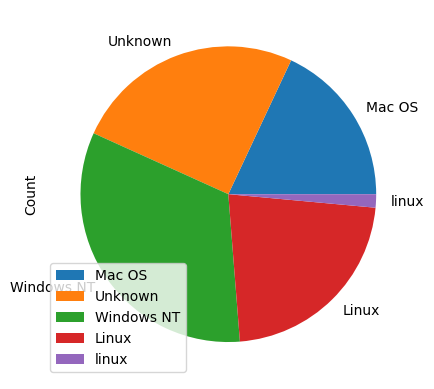

In [49]:
#zakladam ze obrazki maja rozszerzenia png lub jpg
os_regex = r'(Windows NT|[L|l]inux|Mac OS)'

# Find all matches

os_records = lines.map( lambda l: ("Unknown",1) if re.search(os_regex,l) is None else (re.search(os_regex,l).group(0),1) )
os_records.collect()
os_records_count = os_records.reduceByKey(lambda a, b: a + b)
os_records_count = os_records_count.collect()
df = pd.DataFrame(os_records_count, columns=['OS', 'Count'])
df.plot.pie(y='Count', labels=df['OS'])



Oszacować jaki procent ruchu generują boty. Porównać co najmniej 2 sposoby oszacowania.


0.9457


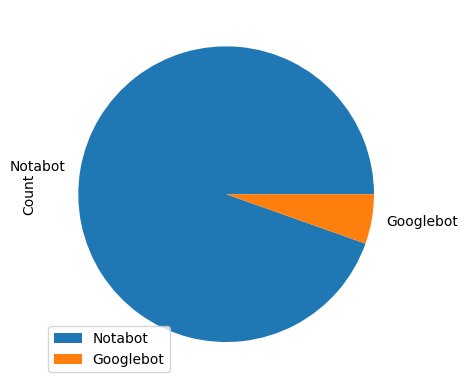

In [50]:
#zakladam ze obrazki maja rozszerzenia png lub jpg
bot_regex = r'Googlebot'

# Find all matches

bot_regex_found = lines.map( lambda l: ("Notabot",1) if re.search(bot_regex,l) is None else (re.search(bot_regex,l).group(0),1) )
bot_regex_found.collect()
bot_regex_count = bot_regex_found.reduceByKey(lambda a, b: a + b)
bot_regex_count = bot_regex_count.collect()
df = pd.DataFrame(bot_regex_count, columns=['Type', 'Count'])
df.plot.pie(y='Count', labels=df['Type'])

print(df['Count'][0]/df['Count'].sum())


In [51]:
#zakladam ze obrazki maja rozszerzenia png lub jpg
bot_regex = r'Googlebot'

# Find all matches

bot_acumm = sc.accumulator(0)
all_acumm = sc.accumulator(0)

def increment_counter(x):
    if x == "Googlebot":
      bot_acumm.add(1)
    all_acumm.add(1)

bot_regex_found = lines.map( lambda l: "Notabot" if re.search(bot_regex,l) is None else re.search(bot_regex,l).group(0) )
bot_regex_found.foreach(increment_counter)


print(1 - bot_acumm.value/all_acumm.value)

0.9457



Narysować mapę z lokalizacjami klientów

In [ ]:
pip install geoip2

In [93]:
import requests

def get_ip_geolocation(ip):
    # You can replace 'your_token' with your IP geolocation API token
    response = requests.get(f'https://ipinfo.io/{ip}/geo', params={'token': ADD_YOUR_TOKEN })
    if response.status_code == 200:
      longitude, latitude = response.json()['loc'].split(',')
      return [longitude,latitude]
    else:
      return [0,0]

get_ip_geolocation("83.149.9.216")

['55.7522', '37.6156']

In [100]:
#Import Geocoder
import geocoder

def printDetails(ip):
    return get_ip_geolocation(ip)

printDetails("83.149.9.216")



['55.7522', '37.6156']

PythonRDD[84] at collect at <ipython-input-91-4cd22bc3d850>:1

In [101]:
ip_loc = ipCounts.map( lambda x: printDetails(x[0]) )

In [102]:
locations = ip_loc.collect()

In [104]:
locations_l = [l for l in locations if l is not None]

In [106]:
locations_df = pd.DataFrame(locations_l, columns=['latitude', 'longitude'])

In [107]:
locations_df

,latitude,longitude
0,55.7522,37.6156
1,-7.7625,110.4317
2,48.5839,7.7455
3,31.2222,121.4581
4,14.6407,-90.5133
...,...,...
1748,50.6942,3.1746
1749,47.0056,28.8575
1750,32.6469,-97.3325
1751,59.9386,30.3141


In [110]:
locations_df['latitude'] = locations_df['latitude'].astype(float)
locations_df['longitude'] = locations_df['longitude'].astype(float)

In [115]:
import folium

# Create a world map
world_map = folium.Map(zoom_start=2)

# Add markers for each geolocation
for location in locations_l:
    folium.Marker(location).add_to(world_map)

# Save the map as an HTML file
world_map.save('ip_geolocation_map.html')

display(world_map)
